## Standard Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../../../")
from matplotlib.animation import FuncAnimation
from ToolkitName.placement import NottDuns, Stationary

## Data Loading

In [3]:
train_data = pd.read_pickle('../dataset/PrecData_train.pickle')
test_data = pd.read_pickle('../dataset/PrecData_test.pickle')
G_train = pd.read_pickle('../dataset/PrecData_Gamma_train.csv')
G_test = pd.read_pickle('../dataset/PrecData_Gamma_test.csv')

train_data = train_data.reset_index(drop=True)
G_train = pd.DataFrame(G_train.values, index=range(G_train.shape[0]), columns=range(G_train.shape[0]))
G_test = pd.DataFrame(G_test.values, index=range(G_test.shape[0]), columns=range(G_test.shape[0]))

## Visualize all sensor locations in the 2D space

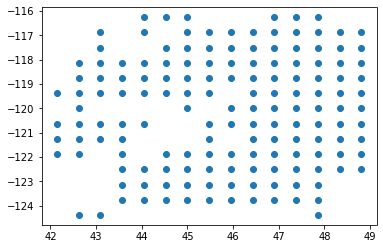

In [4]:
plt.scatter(train_data['lat'], train_data['lon'])

## Visualize train sensor locations in the 2D space

In [5]:
Seed = 42
train_sample = train_data.sample(30, random_state=Seed)
G = G_train.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)

X_train = train_sample[['lat','lon']].values
y_train = train_sample[['data']].values.reshape(-1,1)

(30, 3) (30, 30)


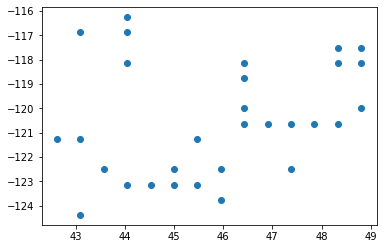

In [6]:
plt.scatter(train_sample['lat'], train_sample['lon'])

In [7]:
nonStat = NottDuns(N=10, eta=1)
nonStat.fit(X_train, y_train, G.values)

## Greedy algorithm for Near Optimal Sensor Placement!

In [8]:
# Initials
N = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = nonStat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'MI')
A_ind_Var, _ = nonStat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'Entropy')
MI = nonStat.MI
Var = nonStat.Var

## Visualizing sensor placements

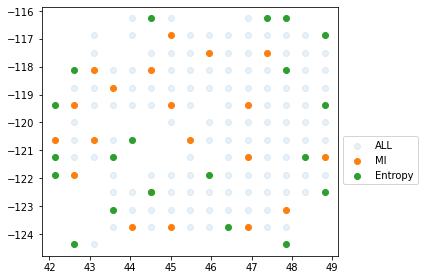

In [9]:
fig, ax = plt.subplots()
iteration = 20
ax.scatter(train_data.lat, train_data.lon, alpha=0.1, label='ALL')
ax.scatter(train_data.loc[A_ind_MI[:iteration]]['lat'], train_data.loc[A_ind_MI[:iteration]]['lon'], label='MI')
ax.scatter(train_data.loc[A_ind_Var[:iteration]]['lat'], train_data.loc[A_ind_Var[:iteration]]['lon'], label='Entropy')
ax.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

## RMSE Plot

In [10]:
Eta = 100
NN = lambda x: len(x)//2
Pilot_ind = []
MI_rms = np.zeros((len(MI), len(test_data.index.unique()[::8])))
Var_rms = np.zeros((len(Var), len(test_data.index.unique()[::8])))
for iter_i, epoch_id in enumerate(test_data.index.unique()[::8]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = test_data.loc[epoch_id].set_index('lat-lon').reset_index(drop=True)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['lat','lon']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['data']].values
        GP_test_X = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['data']].values
        GP_Gamma = G_test.loc[A_ind_Var[:sens_i]+Pilot_ind, A_ind_Var[:sens_i]+Pilot_ind].values
        
        m = NottDuns(NN(GP_train_X), Eta, 'm32')
        m.fit(GP_train_X, GP_train_Y, GP_Gamma)
        GP_predict_Y = m.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['lat','lon']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['data']].values
        GP_test_X = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['data']].values
        GP_Gamma = G_test.loc[A_ind_MI[:sens_i]+Pilot_ind, A_ind_MI[:sens_i]+Pilot_ind].values
        m = NottDuns(NN(GP_train_X), Eta, 'm32')
        m.fit(GP_train_X, GP_train_Y, GP_Gamma)
        GP_predict_Y = m.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms[sens_i, iter_i] = rms

5 29


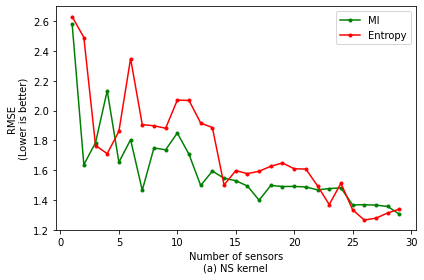

In [11]:
MM = 3

MI_rms_mean = MI_rms[:,0]#.mean(axis=1)
Var_rms_mean = Var_rms[:,0]#.mean(axis=1)

fig, ax = plt.subplots()
tmp = ax.plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)

tmp = ax.plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)
ax.set_xlabel('Number of sensors\n(a) NS kernel')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.show()

## Learning stationary kernel

In [12]:
Seed = 42
train_sample = train_data.sample(30, random_state=Seed)
G = G_train.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)

X_train = train_sample[['lat','lon']].values
y_train = train_sample[['data']].values.reshape(-1,1)


Stat = Stationary(n_restarts=1, kernel_name='m32')
Stat.fit(X_train, y_train)

(30, 3) (30, 30)
Optimization restart 1/1, f = 64.75646983651002


## Greedy placement

In [13]:
N = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = Stat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'MI')
A_ind_Var, _ = Stat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'Entropy')
MI = Stat.MI
Var = Stat.Var

## RMSE plot

In [14]:
Gran = 8
MI_rms1 = np.zeros((len(MI), len(test_data.index.unique()[::Gran])))
Var_rms1 = np.zeros((len(Var), len(test_data.index.unique()[::Gran])))
for iter_i, epoch_id in enumerate(test_data.index.unique()[::Gran]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = test_data.loc[epoch_id].set_index('lat-lon').reset_index(drop=True)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['lat','lon']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind]['data'].values.reshape(-1,1)
        GP_test_X = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)['data'].values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms1[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['lat','lon']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind]['data'].values.reshape(-1,1)
        GP_test_X = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)['data'].values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)

        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms1[sens_i, iter_i] = rms

5 29
Optimization restart 1/1, f = 153.39097691428478
Optimization restart 1/1, f = 132.55033997853945


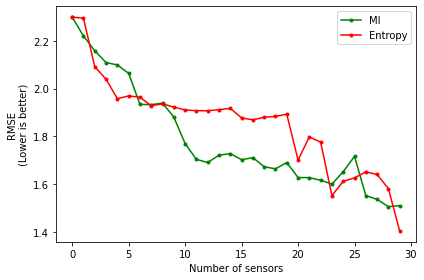

In [15]:
MM = 3
MI_rms_mean = MI_rms1.mean(axis=1)
Var_rms_mean = Var_rms1.mean(axis=1)

fig, ax = plt.subplots()
tmp = ax.plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)
tmp = ax.plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)
ax.set_xlabel('Number of sensors')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.show()